In [65]:
import matplotlib.pyplot as plt
import numpy as np
# import scipy.io
from torch.optim import Adam
import torch.nn.functional as F
import torch
# import seaborn as sns

from gglm.glm.base import GLM
from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
# from gglm.utils import shift_array
from kernel.fun import KernelFun
from sptr.sptr import SpikeTrain
# from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# tau = 10
# weight = torch.from_numpy(KernelFun.gaussian_delta(tau).interpolate(np.arange(-4*tau, 4*tau, 1)))[None, None, :]

# def kernel(r1_i, r2):
#     aux1 = F.conv1d(r1_i.T[:, None, :].double(), weight, padding=(weight.shape[2] - 1) // 2)
#     aux2 = F.conv1d(r2.T[:, None, :].double(), weight, padding=(weight.shape[2] - 1) // 2)
# #     print(aux1.shape, aux2.shape)
#     return torch.sum(aux1 * aux2, dim=(1, 2))

In [67]:

# kernel(mask_spikes_te_torch, torch.from_numpy(mask_spikes_fr_ml))
# aux2 = F.conv1d(mask, weight, padding=(weight.shape[2] - 1) // 2)
# plt.plot(aux1[0, 0, :])

Starting gradient ascent... 

 Iteration 108 of 200 | Elapsed time: 3.27 seconds | objective=-8077.81
 
 Iteration 108 of 200 | Converged | Elapsed time: 0.0544 minutes | Log posterior is monotonic 

u0 true/fit -4 -4.03677438596117


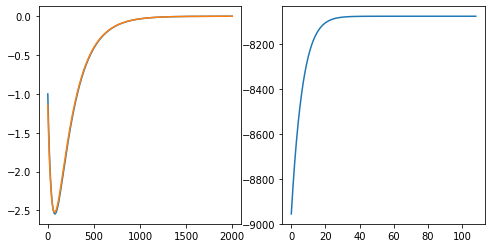

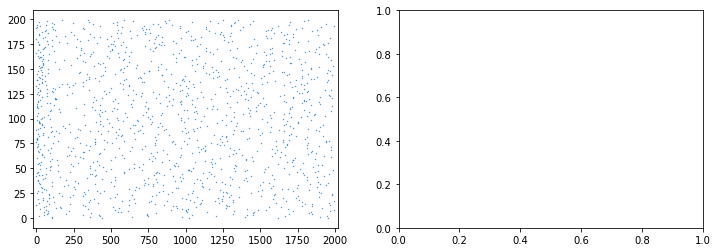

In [114]:
# num_epochs = 200
# lr = 5e-2

n = 200
# eta_true = KernelFun.exponential([50], coefs=[-5])
eta_true = KernelFun.exponential([50, 200], coefs=[4, -5])
glm_true = GLM(u0=-4, eta=eta_true.copy())

t = np.arange(0, 2000, 1)
_, _, mask_spikes_te = glm_true.sample(t, shape=(n,))
mask_spikes_te_torch = torch.from_numpy(mask_spikes_te.copy())
st_dc = SpikeTrain(t, mask_spikes_te)

# eta_fit = KernelFun.exponential([50], coefs=[0])
eta_fit = KernelFun.exponential([50, 200], coefs=[2, -3])

glm_fit = GLM(u0=-3.6, eta=eta_fit.copy())
opt = glm_fit.fit(st_dc.t, st_dc.mask, verbose=True, newton_kwargs=dict(stop_cond=1e-11))

u_fr_ml, r_fr_ml, mask_spikes_fr_ml = glm_fit.sample(t, shape=(n, ))

print('u0 true/fit', glm_true.u0, glm_fit.u0)
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
glm_true.eta.plot(ax=ax1)
glm_fit.eta.plot(ax=ax1)
ax2.plot(opt.obj_iterations)

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
st_dc.plot(ax=ax1, marker='.', ms=0.7)

 epoch 49 of 50 loss 1.9388786076
 6.485 6.36

u0 true/fit -4 -4.3138694911097035


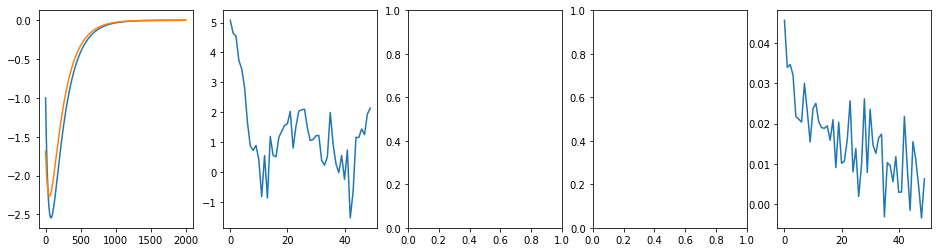

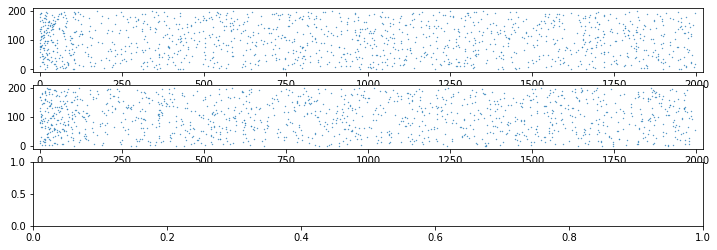

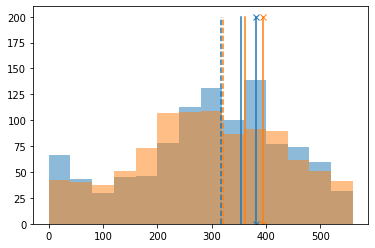

In [132]:
# eta_fit = KernelFun.exponential([50], coefs=[-2.5])
eta_fit = KernelFun.exponential([50, 200], coefs=[2, -3])
mmdglm = MMDGLM(u0=-5, eta=eta_fit.copy())

# eta_fit = KernelFun.exponential([50, 200], coefs=[4, -5])
# mmdglm = MMDGLM(u0=-4, eta=eta_fit.copy())

# kernel = KernelFun.gaussian_delta(50)

# lam_mmd = 1e-2
# def mean_isi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi) for _isi in isi]).double()
#     return isi
# phi, kernel = mean_isi, None

# lam_mmd = 1e-8
# def mean2_isi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi**2) for _isi in isi]).double()
#     return isi
# phi, kernel = mean2_isi, None

# lam_mmd = 1e-2 # doesn't really minimize first nor second moments
# def mean_and_mean2_isi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi) + np.mean((_isi)**2)**0.5 for _isi in isi]).double()
#     return isi
# phi, kernel = mean_and_mean2_isi, None

# lam_mmd = 1e-2 # isi_mean
# def kernel(t, mask_spikes1, mask_spikes2):
#     isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
#     isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
#     mu_isi1 = torch.tensor([np.mean(_isi) for _isi in isi1]).double()
#     mu_isi2 = torch.tensor([np.mean(_isi) for _isi in isi2]).double()
#     mu2_isi1 = torch.tensor([np.mean(_isi**2) for _isi in isi1]).double()**0.5
#     mu2_isi2 = torch.tensor([np.mean(_isi**2) for _isi in isi2]).double()**0.5
# #     gramian = np.exp(isi1[:, None] * isi2[None, :] / 5e3)
#     gramian = mu_isi1[:, None] * mu_isi2[None, :] + mu2_isi1[:, None] * mu2_isi2[None, :]
#     return gramian
# phi, kernel = None, kernel

# lam_mmd = 1e-8 # isi_mean
# def phi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(np.exp((_isi / 1e5))) for _isi in isi]).double()
#     return isi

# lam_mmd = 1e0 # isi_mean
# def phi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi) for _isi in isi]).double()
# #     print(isi)
#     isi = torch.exp(-isi / 5e3)
#     return isi

# lam_mmd = 1e0 # isi_mean
# def kernel(t, mask_spikes1, mask_spikes2):
#     isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
#     isi1 = torch.tensor([np.mean(_isi) for _isi in isi1]).double()
#     isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
#     isi2 = torch.tensor([np.mean(_isi) for _isi in isi2]).double()
#     gramian = torch.exp(-(isi1[:, None] - isi2[None, :])**2 / 1e2)
#     return gramian
# phi, kernel = None, kernel

lam_mmd = 1e0 # isi_mean
def kernel(t, mask_spikes1, mask_spikes2):
    isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
    isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
    n1 = int(np.max(np.sum(mask_spikes1.numpy(), 0)) - 1)
    n2 = int(np.max(np.sum(mask_spikes2.numpy(), 0)) - 1)
#     isi1_m = np.zeros((mask_spikes1.shape[0], n1)) * np.nan
#     isi2_m = np.zeros((mask_spikes2.shape[0], n2)) * np.nan
    isi1 = np.stack([np.append(_isi, np.zeros(n1 - len(_isi)) * np.nan) for _isi in isi1], 0)
    isi2 = np.stack([np.append(_isi, np.zeros(n2 - len(_isi)) * np.nan) for _isi in isi2], 0)
    gramian = np.nansum(np.exp(-(isi1[:, None, :, None] - isi2[None, :, None, :])**2 / 1e1), axis=(2, 3))
#     isi1 = torch.tensor([np.mean(_isi) for _isi in isi1]).double()
#     isi2 = torch.tensor([np.mean(_isi) for _isi in isi2]).double()
#     gramian = np.zeros((len(isi1), len(isi2)))
#     for ii, _isi1 in enumerate(isi1):
#         for jj, _isi2 in enumerate(isi2):
# #             gramian[ii, jj] = np.sum([np.exp(-(tau1 - _isi2)**2 / 1e1) for tau1 in _isi1])
#             gramian[ii, jj] = np.sum(np.exp(-(_isi1[:, None] - _isi2[None, :])**2 / 1e1))

    gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kernel

lr = 5e-2
optim = Adam(mmdglm.parameters(), lr=lr, betas=(0.9, 0.999))

loss, mmd, metrics_list = mmdglm.train(t, mask_spikes_te_torch, phi=phi, kernel=kernel, lam_mmd=lam_mmd, optim=optim, 
                                            num_epochs=50, n_batch_fr=n, verbose=True, metrics=None)
loss, mmd = np.array(loss), np.array(mmd)

u_new_fr, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(t, shape=(n, ))
st_fr_mmd = SpikeTrain(t, mask_spikes_fr_mmd)

print('\n', np.mean(np.sum(mask_spikes_te, 0)), np.mean(np.sum(mask_spikes_fr_mmd, 0)))
print('\nu0 true/fit', glm_true.u0, mmdglm.u0)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(16, 4), ncols=5)
glm_true.eta.plot(ax=ax1)
mmdglm.eta.plot(ax=ax1)
ax2.plot(loss)
# ax3.plot(nll)
# ax4.plot(loss - nll)
ax5.plot(lam_mmd * mmd)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3, ncols=1)
st_dc.plot(ax=ax1, marker='.', ms=0.7)
st_fr_mmd.plot(ax=ax2, marker='.', ms=0.7)
# ax3.plot(t, r_fr_mmd[:, 0])

# ax1.set_ylim(-0.5, 2.5)
# ax2.set_ylim(-0.5, 2.5)
# st_te.plot(ax=ax1, marker='|', ms=20, mew=0.7)
# st_fr.plot(ax=ax2, marker='|', ms=20, mew=0.7)
# lw = 1
# ax3.plot(t, r_te, lw=lw)
# ax4.plot(t, r_fr, lw=lw)

isi_d = st_dc.isi_distribution()
isi_fr = st_fr_mmd.isi_distribution()
mu_d = np.mean(isi_d)
mu_fr = np.mean(isi_fr)
mu2_d = np.mean(isi_d**2)
mu2_fr = np.mean(isi_fr**2)
mu2_d = np.mean(isi_d**2)
mu2_fr = np.mean(isi_fr**2)
mu3_d = np.mean(isi_d**3)
mu3_fr = np.mean(isi_fr**3)

bins = np.arange(0, 600, 40)
fig, ax = plt.subplots()
ax.hist(isi_d, alpha=0.5, bins=bins)
ax.hist(isi_fr, alpha=0.5, bins=bins)
ax.plot([mu_d, mu_d], [0, 200], 'C0--')
ax.plot([mu_fr, mu_fr], [0, 200], 'C1--')
ax.plot([mu2_d**0.5, mu2_d**0.5], [0, 200], 'C0-')
ax.plot([mu2_fr**0.5, mu2_fr**0.5], [0, 200], 'C1-')
ax.plot([mu3_d**(1/3), mu3_d**(1/3)], [0, 200], 'C0-x')
ax.plot([mu3_fr**(1/3), mu3_fr**(1/3)], [0, 200], 'C1-x')

In [89]:
mu2_d**0.5, mu2_fr**0.5

(159.80291447039298, 159.5198222176539)

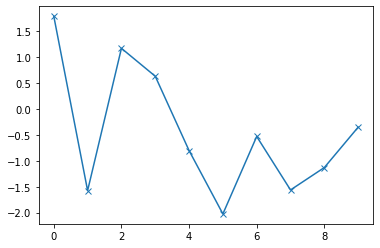

In [83]:
plt.plot(np.random.randn(10), '-x')

NameError: name 'nll' is not defined

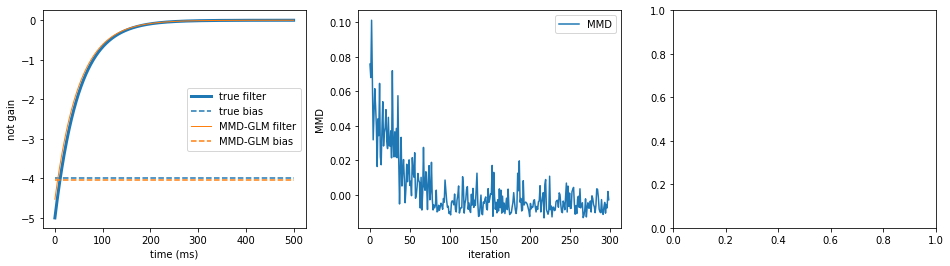

In [25]:
palette = dict(true='C0', mmd='C1')
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 4), ncols=3)
glm_true.eta.plot(ax=ax1, lw=3, color=palette['true'], label='true filter')
ax1.plot([glm_true.eta.support[0], glm_true.eta.support[1]], [glm_true.u0, glm_true.u0], '--', color=palette['true'], label='true bias')
mmdglm.eta.plot(ax=ax1, lw=1, color=palette['mmd'], label='MMD-GLM filter')
ax1.plot([mmdglm.eta.support[0], mmdglm.eta.support[1]], [mmdglm.u0, mmdglm.u0], '--', color=palette['mmd'], label='MMD-GLM bias')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('not gain')
ax1.legend()
ax2.plot(mmd, label='MMD')
ax2.set_xlabel('iteration')
ax2.set_ylabel('MMD')
ax2.legend()
ax3.plot(nll, label='NLL')
ax3.set_xlabel('iteration')
ax3.set_ylabel('NLL')
ax3.legend()

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/learning_history_filter.pdf')

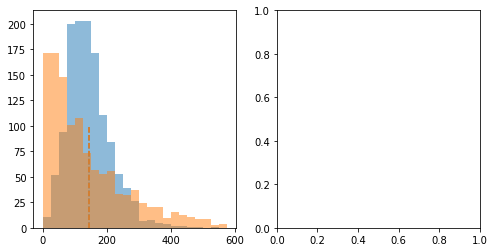

In [107]:
# num_epochs = 200
# lr = 5e-2

n = 100
eta_true = KernelFun.exponential([50], coefs=[-5])
glm_true = GLM(u0=-4, eta=eta_true.copy())

t = np.arange(0, 2000, 1)
_, _, mask_spikes_te = glm_true.sample(t, shape=(n,))
st_dc = SpikeTrain(t, mask_spikes_te)
isi_d = st_dc.isi_distribution(concatenate=False)
mean_d = np.mean(np.concatenate((isi_d)))

eta_fit = KernelFun.exponential([50], coefs=[0])
glm_fit = GLM(u0=-5, eta=eta_fit.copy())
u_fr_ml, r_fr_ml, mask_spikes_fr_ml = glm_fit.sample(t, shape=(n, ))
st_fr = SpikeTrain(t, mask_spikes_fr_ml)
isi_fr = st_fr.isi_distribution(concatenate=False)
mean_fr = np.mean(np.concatenate((isi_fr)))

phi1_d = np.array([np.sum(_isi) for _isi in isi_d])
phi2_d = np.array([np.sum(_isi**2) for _isi in isi_d])
counts_d = np.array([len(_isi**2) for _isi in isi_d])
aux_d = ((phi1_d**2 - phi2_d) / (counts_d * (counts_d - 1)))

phi1_fr = np.array([np.sum(_isi) for _isi in isi_fr])
phi2_fr = np.array([np.sum(_isi**2) for _isi in isi_fr])
counts_fr = np.array([len(_isi**2) for _isi in isi_fr])

gramian_d_d = aux_d[:, None] + aux_d[None, :] - 2 * (phi1_d / counts_d)[:, None] * (phi1_d / counts_d)[None, :]

# n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
# r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)

# norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
# norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
# mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
# d = (norm2_te + norm2_fr - 2 * mean_dot)    

# print('u0 true/fit', glm_true.u0, glm_fit.u0)
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
# glm_true.eta.plot(ax=ax1)
# glm_fit.eta.plot(ax=ax1)
bins = np.arange(0, 600, 25)
ax1.hist(np.concatenate((isi_d)), bins=bins, alpha=0.5)
ax1.hist(np.concatenate((isi_fr)), bins=bins, alpha=0.5)
ax1.plot([mean_d, mean_d], [0, 100], 'C0--')
ax1.plot([mean_fr, mean_fr], [0, 100], 'C1--')

# fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
# st_dc.plot(ax=ax1, marker='.', ms=0.7)

In [106]:
gramian_d_d

array([[-737.49704142, -114.21428571, -143.36813187, ..., -299.29684418,
         -87.43406593, -580.10722611],
       [-114.21428571, -703.30690738, -493.28649922, ..., -520.6996337 ,
        -556.93956044,   91.15467865],
       [-143.36813187, -493.28649922, -330.44976452, ..., -383.21611722,
        -370.51098901,   52.53563104],
       ...,
       [-299.29684418, -520.6996337 , -383.21611722, ..., -449.60552268,
        -410.6007326 , -108.47902098],
       [ -87.43406593, -556.93956044, -370.51098901, ..., -410.6007326 ,
        -422.36813187,  113.2022977 ],
       [-580.10722611,   91.15467865,   52.53563104, ..., -108.47902098,
         113.2022977 , -424.61616162]])